<a href="https://colab.research.google.com/github/amirkasaei/An-Odd-Music-Generator/blob/main/SPB_HW1/Brain_MRI_Classification_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<br>
<font size=6>
Homework 1.2
</font><br>
<font size=4>
Deep learning method
</font>

**First-Name:** Seyed Amir

**Last-Name:** Kasaei

**Student-Id:** 402212214

# Download Data

##### Execute the cell below to download the data required for your homework.

In [143]:
! pip install gdown -q

In [144]:
import gdown

url = 'https://drive.google.com/uc?id=1-2zT-_bKjN2o2QxwSviFwbCzcWE2PnkJ'

output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-2zT-_bKjN2o2QxwSviFwbCzcWE2PnkJ
To: /content/dataset.zip
100%|██████████| 368M/368M [00:02<00:00, 140MB/s]


'dataset.zip'

In [145]:
! unzip dataset.zip

Archive:  dataset.zip
replace patient_ids.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Import

In [146]:
import os
import numpy as np
import seaborn as sns
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
import torch
import random
import pandas as pd
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
import sklearn
from IPython.display import display

# Config

In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
RANDOM_SEED = 42 # Must be used wherever can be used

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [149]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load and Process Data

##### This dataset contains brain MRI images and manual FLAIR abnormality segmentation masks, where each pixel value of masks indicates the presence or absence of cancer (0 and 1, respectively). The images correspond to 110 patients whose IDs are available in the patient_ids.csv file.


In [150]:
data = pd.read_csv('patient_ids.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      110 non-null    object
dtypes: object(1)
memory usage: 1008.0+ bytes


In [151]:
data.head()

,id
0,TCGA_CS_4941
1,TCGA_CS_4942
2,TCGA_CS_4943
3,TCGA_CS_4944
4,TCGA_CS_5393



### **Exercise 1 (5 points)**:

##### Please use the patient_ids.csv file and the images inside the mri_scans folder to generate a Pandas dataframe named mri_df. This dataframe should have columns labeled "patient_id", "image_path", and "mask_path".

In [152]:
path = '/content/mri_scans/'

mri = {}
mri['patient_id'] = []
mri['image_path'] = []
mri['mask_path'] = []

for d in os.listdir(path):
  if d[:12] in data['id'].values:
    for img_dir in os.listdir(path + d):
      if not 'mask' in img_dir:
        patient_id = d[:12]

        image_path = path+d+'/'+img_dir

        mask_dir = img_dir[:-4]+'_mask.tif'
        mask_path = path+d+'/'+mask_dir

        if mask_dir in os.listdir(path + d):
          mri['patient_id'].append(patient_id)
          mri['image_path'].append(image_path)
          mri['mask_path'].append(mask_path)

mri_df = pd.DataFrame(mri)

assert len(mri_df) == 3929
mri_df.head()

,patient_id,image_path,mask_path
0,TCGA_DU_5871,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...
1,TCGA_DU_5871,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...
2,TCGA_DU_5871,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...
3,TCGA_DU_5871,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...
4,TCGA_DU_5871,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...



### **Exercise 2 (3 points)**:

##### Append a has_cancer column to the mri_df DataFrame, with values 0 indicating the absence of cancer and 1 indicating the presence of cancer. Then, convert the column to string type.

In [153]:
def is_cancerous(mask_path):
    mask = cv2.imread(mask_path)
    if mask.any():
      return 1
    else:
      return 0

mri_df['has_cancer'] = mri_df['mask_path'].apply(lambda x: is_cancerous(x))
mri_df.head()

,patient_id,image_path,mask_path,has_cancer
0,TCGA_DU_5871,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,1
1,TCGA_DU_5871,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,0
2,TCGA_DU_5871,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,1
3,TCGA_DU_5871,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,0
4,TCGA_DU_5871,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,/content/mri_scans/TCGA_DU_5871_19941206/TCGA_...,0


# Exploratory Data Analysis


### **Exercise 3 (1 points)**:

##### Calculate the number of images exhibiting the presence and absence of cancer.

In [154]:
count = mri_df['has_cancer'].value_counts()
print('number of images exhibiting the absence of cancer:', count[0])
print('number of images exhibiting the presence of cancer:', count[1])

number of images exhibiting the absence of cancer: 2556
number of images exhibiting the presence of cancer: 1373



### **Exercise 4 (3 points)**:

##### Determine the proportion of pixels designated as cancerous in relation to the total pixel count. Perform this calculation first for all MRI images and subsequently for images displaying signs of cancer.

##### all MRI images

In [155]:
cancerous_pixels_count = 0
total_pixels_count = 0

for i, sample in mri_df.iterrows():
  mask = cv2.imread(sample['mask_path'])
  cancerous_pixels_count += np.count_nonzero(mask)
  total_pixels_count += mask.size

print(f'The proportaion of cancerous pixels = {100 * cancerous_pixels_count / total_pixels_count}%')
print(f'The proportaion of non-cancerous pixels = {100 * (total_pixels_count - cancerous_pixels_count) / total_pixels_count}%')

The proportaion of cancerous pixels = 1.0298824334575434%
The proportaion of non-cancerous pixels = 98.97011756654246%


##### images displaying signs of cancer

In [156]:
cancerous_pixels_count = 0
total_pixels_count = 0

for i, sample in mri_df.iterrows():
  if sample['has_cancer'] == 1:
    mask = cv2.imread(sample['mask_path'])
    cancerous_pixels_count += np.count_nonzero(mask)
    total_pixels_count += mask.size

print(f'The proportaion of cancerous pixels = {100 * cancerous_pixels_count / total_pixels_count}%')
print(f'The proportaion of non-cancerous pixels = {100 * (total_pixels_count - cancerous_pixels_count) / total_pixels_count}%')

The proportaion of cancerous pixels = 2.9471289738198743%
The proportaion of non-cancerous pixels = 97.05287102618013%


# Visualization

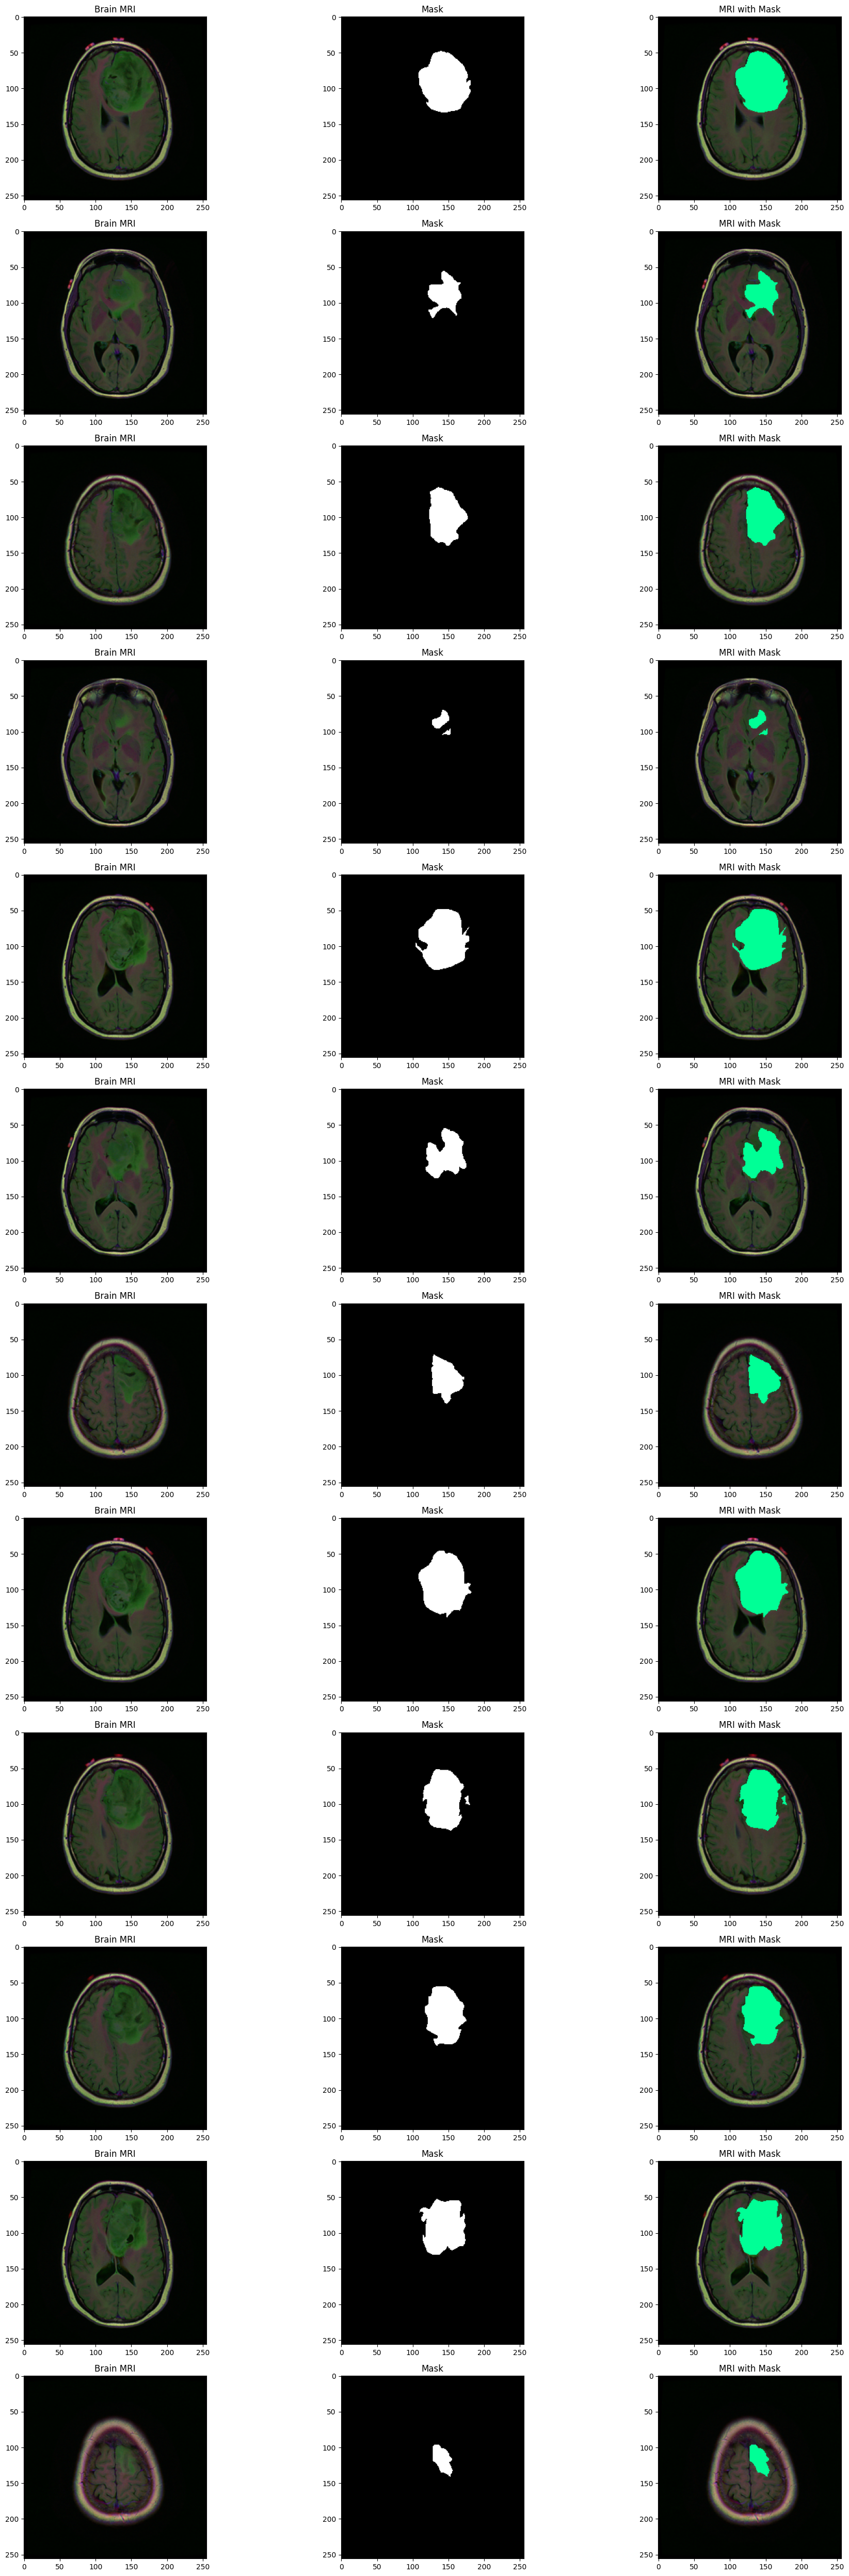

In [157]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for has_cancer in mri_df['has_cancer']:
    if (has_cancer==1):
        img = io.imread(mri_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        img[mask==255] = (0,255,150)
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break

fig.tight_layout()

# Creata Dataset & DataLoader

#### Splitting To Train/Test/Val

##### Also, you are free to modify the below code.

In [172]:
import pandas as pd
from sklearn.model_selection import train_test_split

mri_df['has_cancer'] = mri_df['has_cancer'].apply(lambda x: str(x))

X_train, X_test, y_train, y_test = train_test_split(
    mri_df[['image_path']],
    mri_df[['has_cancer']],
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify = mri_df['has_cancer'],
)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(
    train_df[['image_path']],
    train_df[['has_cancer']],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify = train_df['has_cancer']
)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)

# train_df = pd.concat([train_df_zero, train_df_one], axis=0).reset_index(drop=True)
print(f'train df count: {len(train_df)}')
print(f'test df count: {len(test_df)}')
print(f'validation df count: {len(val_df)}')

train df count: 2828
test df count: 393
validation df count: 708


In [173]:
print(train_df['has_cancer'].value_counts())
print(val_df['has_cancer'].value_counts())
print(test_df['has_cancer'].value_counts())

0    1839
1     989
Name: has_cancer, dtype: int64
0    461
1    247
Name: has_cancer, dtype: int64
0    256
1    137
Name: has_cancer, dtype: int64


### **Exercise 5 (5 points)**:

##### Complete the code for the functions of BrainMRIDataset class (mask pixel values must be either 0 or 1).

In [174]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

class BrainMRIDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.dataframe = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return self.dataframe.shape[0]
    def __getitem__(self, idx):
        image = self.image_transform(cv2.imread(self.dataframe.iloc[idx]['image_path']))
        has_cancer = float(self.dataframe.iloc[idx]['has_cancer'])

        return image, has_cancer


BATCH_SIZE = 64

train_transform = transforms.Compose([
    # TODO
    transforms.ToTensor(),

])

test_transform = transforms.Compose([
    # TODO
    transforms.ToTensor(),
])


train_dataset = BrainMRIDataset(
    train_df,
    image_transform=train_transform,
)
val_dataest = BrainMRIDataset(
    val_df,
    image_transform=test_transform,
)
test_dataset = BrainMRIDataset(
    test_df,
    image_transform=test_transform,
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataest, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Classification**

##### You will be constructing a classification model designed to determine the presence of cancer in an image. To accomplish this task, utilize a pre-trained model (e.g., ResNet, Inception).

### **Exercise 6: Implement Your Classifier (15 points)**:

##### You are free to make every layer frozen or trainable.

In [204]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # ResNet
        self.model = models.resnet18(pretrained=True)
        self.num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(self.num_ftrs, 2)

        # VGG 19
        # self.model = models.vgg19_bn(pretrained=True)
        # self.num_ftrs = self.model.classifier[-1].in_features
        # self.model.classifier[-1] = nn.Linear(self.num_ftrs, 2)


        # for param_name, param in self.model.features.named_parameters():
        #   param.requires_grad = False



    def forward(self, x):
        return self.model(x)


model = Classifier()
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



Classifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

### **Exercise 7 (5 points)**:

##### Define your optimizer, criterion, and learning rate scheduler.


##### **Note**: Do not forget to address the class imbalance problem.


In [205]:
import torch.optim as optim
from torch.optim import lr_scheduler

lr = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

### **Exercise 8 & 9 (35 points)**:

##### Complete the code for training and validation.

In [206]:
def train_one_epoch(model, loader, criterion, optimizer, device):

  model.train()  # Set model to training mode

  running_loss = 0.0

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    with torch.set_grad_enabled(True):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

    # statistics
    running_loss += loss.item()

    # scheduler.step()

    return running_loss / len(loader)

def validate_one_epoch(model, loader, criterion, device):
  model.eval()   # Set model to evaluate mode
  running_loss = 0.0
  running_accuracy = 0.0
  running_precision = 0.0
  running_recall = 0.0
  running_f1_score = 0.0

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    # statistics
    running_loss += loss.item()

    running_accuracy += sklearn.metrics.accuracy_score(labels.cpu(), preds.cpu())
    running_precision += sklearn.metrics.precision_score(labels.cpu(), preds.cpu(), zero_division=0)
    running_recall += sklearn.metrics.recall_score(labels.cpu(), preds.cpu(), zero_division=0)
    running_f1_score += sklearn.metrics.f1_score(labels.cpu(), preds.cpu(), zero_division=0)

  loss = running_loss / len(loader)
  accuracy = running_accuracy / len(loader)
  precision = running_precision / len(loader)
  recall = running_recall / len(loader)
  f1_score = running_f1_score / len(loader)


  return loss, accuracy, precision, recall, f1_score

In [207]:
num_epochs = 100

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, acc, precision, recall, f1 = validate_one_epoch(model, val_dataloader, criterion, device)
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Loss: {train_loss:.4f} - '
          f'Validation Loss: {val_loss:.4f} - '
          f'Validation: ACC {acc:.4f}% - '
          f'Validation Precision: {precision:.4f}% - '
          f'Validation: Recall {recall:.4f}% - '
          f'Validation F1: {f1:.2f}%')

Epoch [1/100] - Loss: 0.0176 - Validation Loss: 0.5645 - Validation: ACC 0.6810% - Validation Precision: 0.2083% - Validation: Recall 0.0169% - Validation F1: 0.03%
Epoch [2/100] - Loss: 0.0121 - Validation Loss: 0.5068 - Validation: ACC 0.7005% - Validation Precision: 0.6333% - Validation: Recall 0.1160% - Validation F1: 0.19%
Epoch [3/100] - Loss: 0.0072 - Validation Loss: 0.4705 - Validation: ACC 0.7305% - Validation Precision: 0.6129% - Validation: Recall 0.2831% - Validation F1: 0.38%
Epoch [4/100] - Loss: 0.0125 - Validation Loss: 0.4502 - Validation: ACC 0.7474% - Validation Precision: 0.6355% - Validation: Recall 0.3401% - Validation F1: 0.44%
Epoch [5/100] - Loss: 0.0103 - Validation Loss: 0.4368 - Validation: ACC 0.7565% - Validation Precision: 0.6431% - Validation: Recall 0.3784% - Validation F1: 0.47%
Epoch [6/100] - Loss: 0.0118 - Validation Loss: 0.4236 - Validation: ACC 0.7643% - Validation Precision: 0.6466% - Validation: Recall 0.4143% - Validation F1: 0.50%
Epoch [7/1

In [209]:
model_path = '/content/drive/MyDrive/AI/Brain MRI Classification/resnet18.pt'
torch.save(model, model_path)

# **Exercise 10: Evaluation (30 points)**:

##### Evaluate your model with the metrics you defined earlier on your test data (f1 > 0.7 is required).

In [218]:
model_path = '/content/drive/MyDrive/AI/Brain MRI Classification/resnet18.pt'

In [219]:
model = torch.load(model_path)

In [220]:
def evaluate(model, loader, criterion, device):

  # Each epoch has a training and validation phase
  model.eval()   # Set model to evaluate mode

  running_loss = 0.0
  running_accuracy = 0.0
  running_precision = 0.0
  running_recall = 0.0
  running_f1_score = 0.0

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    # statistics
    running_loss += loss.item()
    running_accuracy += sklearn.metrics.accuracy_score(labels.cpu(), preds.cpu())
    running_precision += sklearn.metrics.precision_score(labels.cpu(), preds.cpu(), zero_division=0)
    running_recall += sklearn.metrics.recall_score(labels.cpu(), preds.cpu(), zero_division=0)
    running_f1_score += sklearn.metrics.f1_score(labels.cpu(), preds.cpu(), zero_division=0)

  loss = running_loss / len(loader)
  accuracy = running_accuracy / len(loader)
  precision = running_precision / len(loader)
  recall = running_recall / len(loader)
  f1_score = running_f1_score / len(loader)


  print(f'Test Loss: {loss:.4f} - '
        f'Test: ACC {accuracy:.4f}% - '
        f'Test Precision: {precision:.4f}% - '
        f'Test: Recall {recall:.4f}% - '
        f'Test F1: {f1_score:.2f}%')

evaluate(model, test_dataloader, criterion, device)

Test Loss: 0.1584 - Test: ACC 0.9442% - Test Precision: 0.9020% - Test: Recall 0.9462% - Test F1: 0.92%



# **Exercise 11: Report (5 points)**:

##### Visualize the confusion matrix and find the weaknesses of your model (describe it in 2 lines).

In [213]:
def plot_confusionmatrix(y_train_pred,y_train, classes):
  print('Confusion matrix')
  cf = sklearn.metrics.confusion_matrix(y_train_pred,y_train)
  sns.heatmap(cf,annot=True,yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='g')
  plt.tight_layout()
  plt.show()

In [214]:
classes = ['not cancerous', 'cancerous']

def report(model, loader, device, classes):

  # Each epoch has a training and validation phase
  model.eval()   # Set model to evaluate mode

  y_pred = []
  y_true = []

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      y_pred.extend(preds.cpu())
      y_true.extend(labels)

  plot_confusionmatrix(y_pred, y_true, classes)

Confusion matrix


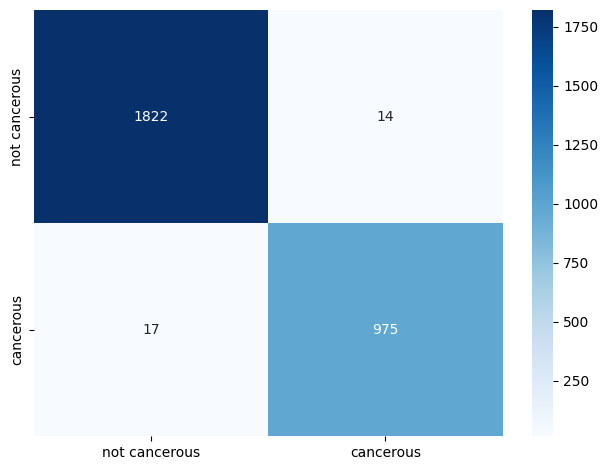

In [215]:
report(model, train_dataloader, device, classes)

Confusion matrix


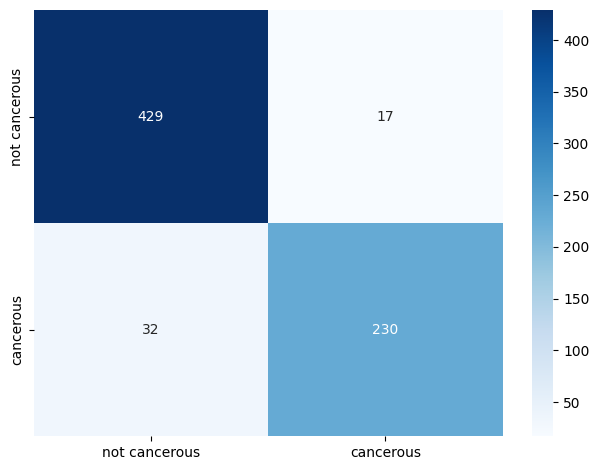

In [216]:
report(model, val_dataloader, device, classes)

Confusion matrix


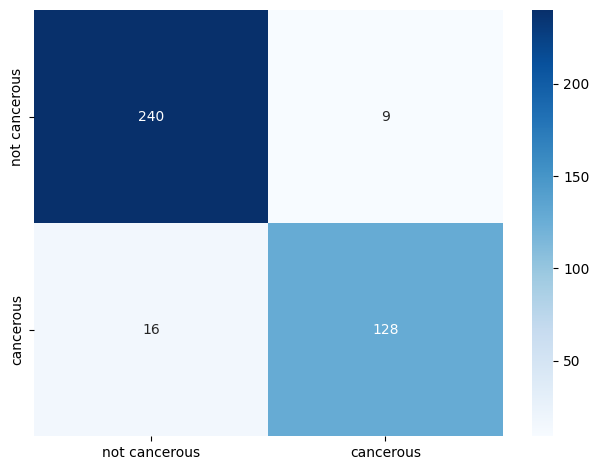

In [217]:
report(model, test_dataloader, device, classes)

#### Your description:
according to confusion matrixes for all domains (train, val, test), we can see that most of the errors are flase negative ones, so the model had a little more problem on predicting cancerous samples, having a lower recall on negative class


# **Exercise 12: Feature Space Visualization (20 points)**:


##### You have trained and evaluated your model. Now, for each image in the trainset, calculate it's "feature space" (After Applying Final Pooling).

##### Use **TSNE** to visualize the points in a 2D plane (Set color of each point based on it's class).


In [221]:
# Use the model object to select the desired layer (the ‘avgpool’ layer selected here is at the end of ResNet-19)
layer = model.model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

t = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [222]:
from torch.autograd import Variable

def get_vector(image):
    # Create a PyTorch tensor with the transformed image
    image = image.to(device)
    t_img = t(image)
    # Create a vector of zeros that will hold our feature vector
    # The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)

    # Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.flatten())                 # <-- flatten

    # Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # Run the model on our transformed image
    with torch.no_grad():                               # <-- no_grad context
        model(t_img.unsqueeze(0))                       # <-- unsqueeze
    # Detach our copy function from the layer
    h.remove()
    # Return the feature vector
    return my_embedding

In [223]:
X = []
y = []

for i, o in train_dataset:
  X.append(np.array(get_vector(i)))
  y.append(str(o))

X = np.array(X)
y = np.array(y)

In [224]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_

1.0389013290405273

In [225]:
import plotly.express as px

fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y, color_discrete_map={'0.0' : "blue", '1.0': "red"})
fig.update_layout(
    title="TSNE Visualization",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

# **Refrences**
- [becominghuman.ai](https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c)

- [datacamp](https://www.datacamp.com/tutorial/introduction-t-sne)